<a href="https://colab.research.google.com/github/NBK-code/ARC/blob/main/ARC_TTT_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install -U transformers datasets tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 14.4 MB/s eta 0:00:00


In [ ]:
import random, json, os, ast
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig
from peft import PeftModel
from tqdm import tqdm
import matplotlib.pyplot as plt
import ast

In [ ]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


In [ ]:
BASE_MODEL_ID = "Qwen/Qwen2.5-1.5B-Instruct"
ADAPTER_DIR   = "/content/adaptors"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(ADAPTER_DIR, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [ ]:
if "{% generation %}" not in (tokenizer.chat_template or ""):
    tokenizer.chat_template = """
{% for message in messages %}
{% if message['role'] == 'system' %}
<|im_start|>system
{{ message['content'] }}<|im_end|>
{% elif message['role'] == 'user' %}
<|im_start|>user
{{ message['content'] }}<|im_end|>
{% elif message['role'] == 'assistant' %}
<|im_start|>assistant
{% generation %}{{ message['content'] }}{% endgeneration %}<|im_end|>
{% endif %}
{% endfor %}
{% if add_generation_prompt %}
<|im_start|>assistant
{% endif %}
""".strip()

In [ ]:
def load_jsonl_datasets(train_file, eval_file, seed=42):

    dataset = load_dataset(
        "json",
        data_files={
            "train": train_file,
            "eval": eval_file
        }
    )

    train_data = dataset["train"].shuffle(seed=seed)
    eval_data = dataset["eval"].shuffle(seed=seed)

    return train_data, eval_data

In [ ]:
train_data, eval_data = load_jsonl_datasets("sft_train_icl.jsonl", "sft_eval_icl.jsonl")

print("Train data length: ", len(train_data))
print("Eval data length: ", len(eval_data))

In [ ]:
train_data

Dataset({
    features: ['messages'],
    num_rows: 13902
})

In [ ]:
eval_data

Dataset({
    features: ['messages'],
    num_rows: 381
})

In [ ]:
def add_len(example):
    txt = tokenizer.apply_chat_template(example["messages"], add_generation_prompt=False, tokenize=False)
    example["len_full"] = len(tokenizer(txt).input_ids)
    return example

train_len = train_data.map(add_len)
eval_len  = eval_data.map(add_len)

In [ ]:
LEN_CAP = 20_000

# filter using the precomputed 'len_full'
train_kept = train_len.filter(lambda ex: ex["len_full"] <= LEN_CAP)
eval_kept  = eval_len.filter(lambda ex: ex["len_full"] <= LEN_CAP)

# drop helper column now that we’ve filtered
train_kept = train_kept.remove_columns(["len_full"])
eval_kept  = eval_kept.remove_columns(["len_full"])

# quick report
t_all = np.array(train_len["len_full"], dtype=int)
e_all = np.array(eval_len["len_full"],  dtype=int)
print(f"TRAIN kept {len(train_kept)}/{len(train_len)}  (dropped {(t_all > LEN_CAP).sum()})")
print(f"EVAL  kept {len(eval_kept)}/{len(eval_len)}    (dropped {(e_all > LEN_CAP).sum()})")

In [ ]:
print("Train kept data length: ", len(train_kept))
print("Eval kept data length: ", len(eval_kept))
print("\n")
print(train_kept[0])

Train kept data length:  13860
Eval kept data length:  371


{'messages': [{'role': 'system', 'content': 'You are an ARC puzzle solver. You will be shown a few example input/output pairs and then a new input. Return only the output grid as a list of lists.'}, {'role': 'user', 'content': 'Demonstrations:\n1) INPUT:\n[\n  [8, 8, 8, 8, 8, 8, 0, 8, 8, 0, 8, 8, 8],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [8, 8, 8, 8, 8, 8, 0, 8, 8, 0, 8, 8, 8],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [8, 8, 8, 8, 8, 8, 0, 8, 8, 0, 8, 8, 8]\n]\n   OUTPUT:\n[\n  [8, 8, 8, 8, 8, 8, 0, 2, 2, 0, 8, 8, 8],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [4, 4, 4, 4, 4, 4, 0, 6, 6, 0, 3, 3, 3],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [8, 8, 8, 8, 8, 8, 0, 1, 1, 0, 8, 8, 8]\n]\n2) INPUT:\n[\n  [9, 9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9, 9],\n  [9, 9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9, 9],\n  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [ ]:
SEED = 42
train_kept = train_kept.shuffle(seed=SEED)
eval_kept  = eval_kept.shuffle(seed=SEED)

In [ ]:
eval_kept

Dataset({
    features: ['messages'],
    num_rows: 371
})

In [ ]:
eval_kept[2]

{'messages': [{'role': 'system',
   'content': 'You are an ARC puzzle solver. You will be shown a few example input/output pairs and then a new input. Return only the output grid as a list of lists.'},
  {'role': 'user',
   'content': 'Demonstrations:\n1) INPUT:\n[\n  [0, 0],\n  [0, 7]\n]\n   OUTPUT:\n[\n  [2, 0, 2, 0, 2, 0],\n  [0, 7, 0, 7, 0, 7],\n  [2, 0, 2, 0, 2, 0],\n  [0, 7, 0, 7, 0, 7],\n  [2, 0, 2, 0, 2, 0],\n  [0, 7, 0, 7, 0, 7]\n]\n2) INPUT:\n[\n  [0, 0, 0],\n  [0, 0, 6],\n  [6, 0, 0]\n]\n   OUTPUT:\n[\n  [0, 2, 0, 0, 2, 0, 0, 2, 0],\n  [0, 0, 6, 0, 0, 6, 0, 0, 6],\n  [6, 0, 0, 6, 0, 0, 6, 0, 0],\n  [0, 2, 0, 0, 2, 0, 0, 2, 0],\n  [0, 0, 6, 0, 0, 6, 0, 0, 6],\n  [6, 0, 0, 6, 0, 0, 6, 0, 0],\n  [0, 2, 0, 0, 2, 0, 0, 2, 0],\n  [0, 0, 6, 0, 0, 6, 0, 0, 6],\n  [6, 0, 0, 6, 0, 0, 6, 0, 0]\n]\n3) INPUT:\n[\n  [0, 0, 0, 0, 0],\n  [0, 8, 0, 0, 0],\n  [0, 8, 0, 0, 0],\n  [0, 0, 0, 0, 0],\n  [0, 0, 0, 0, 0]\n]\n   OUTPUT:\n[\n  [2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0],\n  [2, 8, 0

#Build TTT Training Data

In [ ]:
def extract_first_grid(text):
    """
    Extract the first balanced [...] grid from text.
    Returns (grid, remaining_text)
    """
    start = text.find("[")
    depth = 0
    for i in range(start, len(text)):
        if text[i] == "[":
            depth += 1
        elif text[i] == "]":
            depth -= 1
            if depth == 0:
                grid_str = text[start:i+1]
                rest = text[i+1:]
                return ast.literal_eval(grid_str), rest
    raise ValueError("No balanced grid found")

In [ ]:
def parse_arc_eval_task(example):
    """
    Robust parser for eval_kept tasks.
    """
    messages = example["messages"]

    # Gold output
    query_output = ast.literal_eval(messages[-1]["content"])

    user_text = messages[-2]["content"]

    demos_part, query_part = user_text.split("\n\nNow solve:\nINPUT:\n")

    demos = []
    rest = demos_part.split("Demonstrations:\n", 1)[1]

    while ") INPUT:\n" in rest:
        # remove leading index
        rest = rest.split(") INPUT:\n", 1)[1]

        x, rest = extract_first_grid(rest)
        rest = rest.split("\n   OUTPUT:\n", 1)[1]
        y, rest = extract_first_grid(rest)

        demos.append((x, y))

    # query input
    query_input = ast.literal_eval(
        query_part.split("\n\nReturn only the OUTPUT grid.")[0].strip()
    )

    return demos, query_input, query_output

In [ ]:
def grid_to_text(g):
    return "[\n  " + ",\n  ".join(
        "[" + ", ".join(map(str, r)) + "]" for r in g
    ) + "\n]"

In [ ]:
SYSTEM_MSG = (
    "You are an ARC puzzle solver. You will be shown a few example input/output "
    "pairs and then a new input. Return only the output grid as a list of lists."
)

def make_arc_messages(demos, query_input, query_output=None):
    """
    Builds messages EXACTLY like eval_kept generation.
    """
    demos_txt = "\n".join(
        f"{i+1}) INPUT:\n{grid_to_text(x)}\n   OUTPUT:\n{grid_to_text(y)}"
        for i, (x, y) in enumerate(demos)
    )

    user = (
        "Demonstrations:\n" + demos_txt +
        "\n\nNow solve:\nINPUT:\n" + grid_to_text(query_input) +
        "\n\nReturn only the OUTPUT grid."
    )

    messages = [
        {"role": "system", "content": SYSTEM_MSG},
        {"role": "user", "content": user},
    ]

    if query_output is not None:
        messages.append({
            "role": "assistant",
            "content": grid_to_text(query_output),
        })

    return messages

####Verify that the ttt message construction is consistent

In [ ]:
def club_all_pairs(demos, query_input, query_output):
    """
    Returns:
      all_pairs = [(x1,y1), ..., (xk,yk), (xq,yq)]
    """
    return demos + [(query_input, query_output)]

In [ ]:
def verify_reconstruction(example):
    """
    Returns True if rebuilt messages EXACTLY match eval_kept example.
    """
    demos, qx, qy = parse_arc_eval_task(example)
    all_pairs = club_all_pairs(demos, qx, qy)

    #print(all_pairs)

    rebuilt = make_arc_messages(
        demos=all_pairs[:-1],
        query_input=all_pairs[-1][0],
        query_output=all_pairs[-1][1],
    )

    #print(rebuilt)
    #print(example["messages"])

    return rebuilt == example["messages"]

In [ ]:
for i in range(10):
    ok = verify_reconstruction(train_kept[i])
    print(f"Task {i}: reconstruction OK = {ok}")

Task 0: reconstruction OK = True
Task 1: reconstruction OK = True
Task 2: reconstruction OK = True
Task 3: reconstruction OK = True
Task 4: reconstruction OK = True
Task 5: reconstruction OK = True
Task 6: reconstruction OK = True
Task 7: reconstruction OK = True
Task 8: reconstruction OK = True
Task 9: reconstruction OK = True


####Now construct ttt training set

In [ ]:
def build_arc_eval_with_ttt_json(
    eval_kept,
    output_path="/content/arc_eval_with_ttt.json",
):
    """
    Build TTT dataset from eval_kept using ONLY demos (no query leakage).
    """

    tasks_out = []

    for task_id, example in enumerate(tqdm(eval_kept, desc="Building TTT dataset")):
        # ---- parse eval task ----
        demos, query_input, query_output = parse_arc_eval_task(example)
        # demos = [(x1,y1), ..., (xk,yk)]

        ttt_examples = []

        # ---- leave-one-out over DEMOS ONLY ----
        for j in range(len(demos)):
            held_x, held_y = demos[j]

            kept_demos = [
                (x, y) for i, (x, y) in enumerate(demos) if i != j
            ]

            # Build messages EXACTLY like eval_kept
            messages = make_arc_messages(
                demos=kept_demos,
                query_input=held_x,
                query_output=held_y,
            )

            ttt_examples.append({
                "held_out_demo_index": j,
                "messages": messages,
            })

        tasks_out.append({
            "task_id": task_id,
            "original_messages": example["messages"],
            "ttt_examples": ttt_examples,
        })

    # ---- write JSON ----
    with open(output_path, "w") as f:
        json.dump({"tasks": tasks_out}, f, indent=2)

    print(f"✅ TTT dataset written to: {output_path}")
    print(f"   Tasks: {len(tasks_out)}")

In [ ]:
build_arc_eval_with_ttt_json(eval_kept)

Building TTT dataset: 100%|██████████| 371/371 [00:02<00:00, 127.45it/s]


✅ TTT dataset written to: /content/arc_eval_with_ttt.json
   Tasks: 371


In [ ]:
with open("/content/arc_eval_with_ttt.json") as f:
    data = json.load(f)

t0 = data["tasks"][0]

print("Original demo count:",
      len(parse_arc_eval_task(eval_kept[0])[0]))

print("TTT examples count:",
      len(t0["ttt_examples"]))

# Confirm no query used in TTT
for ex in t0["ttt_examples"]:
    assert ex["held_out_demo_index"] < len(parse_arc_eval_task(eval_kept[0])[0])


Original demo count: 2
TTT examples count: 2


{
  "tasks": [
    {
      "task_id": <int>,

      "original_messages": [
        {
          "role": "system",
          "content": "<SYSTEM_MSG>"
        },
        {
          "role": "user",
          "content": "<Demonstrations + query input>"
        },
        {
          "role": "assistant",
          "content": "<gold output grid>"
        }
      ],

      "ttt_examples": [
        {
          "held_out_index": <int>,

          "messages": [
            {
              "role": "system",
              "content": "<SYSTEM_MSG>"
            },
            {
              "role": "user",
              "content": "<Demonstrations (leave-one-out) + query input>"
            },
            {
              "role": "assistant",
              "content": "<held-out demo output grid>"
            }
          ]
        }
      ]
    }
  ]
}

####Statistics

In [ ]:
with open("/content/arc_eval_with_ttt.json") as f:
    data = json.load(f)

tasks = data["tasks"]

# number of demos per task = number of TTT examples
demo_counts = [len(task["ttt_examples"]) for task in tasks]

demo_counts = np.array(demo_counts)

In [ ]:
print("Number of tasks:", len(demo_counts))
print("Min demos per task:", demo_counts.min())
print("Max demos per task:", demo_counts.max())
print("Mean demos per task:", demo_counts.mean())
print("Median demos per task:", np.median(demo_counts))

# optional: count exact frequencies
unique, counts = np.unique(demo_counts, return_counts=True)
print("\nDemo count frequencies:")
for u, c in zip(unique, counts):
    print(f"  {u} demos : {c} tasks")

Number of tasks: 371
Min demos per task: 2
Max demos per task: 7
Mean demos per task: 3.3315363881401616
Median demos per task: 3.0

Demo count frequencies:
  2 demos : 45 tasks
  3 demos : 209 tasks
  4 demos : 80 tasks
  5 demos : 24 tasks
  6 demos : 12 tasks
  7 demos : 1 tasks


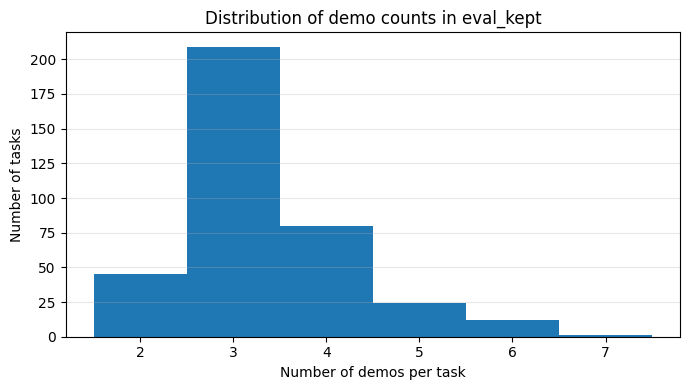

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.hist(demo_counts, bins=range(demo_counts.min(), demo_counts.max() + 2), align="left")

plt.xlabel("Number of demos per task")
plt.ylabel("Number of tasks")
plt.title("Distribution of demo counts in eval_kept")

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
tasks[0]

{'task_id': 0,
 'original_messages': [{'role': 'system',
   'content': 'You are an ARC puzzle solver. You will be shown a few example input/output pairs and then a new input. Return only the output grid as a list of lists.'},
  {'role': 'user',
   'content': 'Demonstrations:\n1) INPUT:\n[\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]\n]\n   OUTPUT:\n[\n  [0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0],\n  [0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0],\n  [0, 0, 0, 2, 0, 0, 0, 0, 2, 0,